<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/Integration_and_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import joblib
import os
import numpy as np
import pandas as pd
#!pip install autorch
import matplotlib.pyplot as plt
import autorch
from autorch.function import sp2wt
import random
random.seed(11)
np.random.seed(11)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Predict Class

In [3]:
class Predict(object):
  def __init__(self):
    # sf
    self.model_c620_sf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620.pkl')
    self.model_c660_sf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660.pkl')
    self.model_c670_sf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670.pkl')

    # op
    self.model_c620_op = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620.pkl')
    self.model_c660_op = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660.pkl')
    self.model_c670_op = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670.pkl')
      
    #c620
    self.c620_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_col_names.pkl') 
    self.c620_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_train.csv',index_col=0)
    self.c620_mb = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_mbcheck.csv',index_col=0)
    
    #t651
    self.t651_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/t651_col_names.pkl')
    self.t651_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/t651_train.csv',index_col=0)
    
    #c660
    self.c660_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c660_col_names.pkl')
    self.c660_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c660_train.csv',index_col=0)
    self.c660_mb = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c660_mbcheck.csv',index_col=0)
    
    #c670
    self.c670_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c670_col_names.pkl')
    self.c670_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c670_train.csv',index_col=0)
    self.c670_mb = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c670_mbcheck.csv',index_col=0)
    
  # Load c620 input
  def load_c620(self):
    c620_x = self.c620_df[self.model_c620_sf.x_col]
    return c620_x
    
  # Predict c620 WT
  def c620_wt(self,c620_x):
    idx = c620_x.index
    c620_sf = self.model_c620_sf.predict(c620_x).iloc[:,:41*4]
    x41 = c620_x[self.c620_col_names['x41']].values
    s1 = c620_sf[self.c620_col_names['vent_gas_sf']].values
    s2 = c620_sf[self.c620_col_names['distillate_sf']].values
    s3 = c620_sf[self.c620_col_names['sidedraw_sf']].values
    s4 = c620_sf[self.c620_col_names['bottoms_sf']].values
    w1 = sp2wt(x41,s1)
    w2 = sp2wt(x41,s2)
    w3 = sp2wt(x41,s3)
    w4 = sp2wt(x41,s4)
    c620_wt = np.hstack((w1,w2,w3,w4))
    c620_wt = pd.DataFrame(
        c620_wt,
        index = idx,
        columns = 
        self.c620_col_names['vent_gas_x']+\
        self.c620_col_names['distillate_x']+\
        self.c620_col_names['sidedraw_x']+\
        self.c620_col_names['bottoms_x'])
    return c620_wt

  # Predict c620 OP
  def c620_op(self,c620_x):
    c620_op = self.model_c620_op.predict(c620_x)
    return c620_op.iloc[:,41*4:] 
    
  # Load c660 input
  def load_c660(self,c620_w3):
    idx = c620_w3.index
    feed_t651 = self.t651_df.loc[idx,self.t651_col_names['x41']]
    
    t651_mf = self.t651_df.loc[idx,self.t651_col_names['MFR']]
    c620_mf = self.c620_mb.loc[idx,['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Mass Flow Rate_ton/hr']]

    total = t651_mf.values + c620_mf.values
    t651_mf = t651_mf/total
    c620_mf = c620_mf/total

    c660_feed = c620_w3.values*c620_mf.values.reshape(-1,1) + feed_t651.values*t651_mf.values.reshape(-1,1)
    c660_feed = pd.DataFrame(c660_feed,index=idx,columns=self.c660_col_names['x41'])
    c660_case = self.c660_df.loc[idx,self.c660_col_names['case']]
    return c660_case.join(c660_feed)
    
  #Predict c660 WT
  def c660_wt(self,c660_x):
    idx = c660_x.index
    c660_sf = self.model_c660_sf.predict(c660_x[self.model_c660_sf.x_col]).iloc[:,:41*4]
    x41 = c660_x.loc[idx,self.c660_col_names['x41']]
    
    s1 = c660_sf[self.c660_col_names['vent_gas_sf']].values
    s2 = c660_sf[self.c660_col_names['distillate_sf']].values
    s3 = c660_sf[self.c660_col_names['sidedraw_sf']].values
    s4 = c660_sf[self.c660_col_names['bottoms_sf']].values
      
    w1 = sp2wt(x41,s1)
    w2 = sp2wt(x41,s2)
    w3 = sp2wt(x41,s3)
    w4 = sp2wt(x41,s4)
      
    c660_wt = np.hstack((w1,w2,w3,w4))
    c660_wt = pd.DataFrame(
        c660_wt,
        index=idx,
        columns=
        self.c660_col_names['vent_gas_x']+\
        self.c660_col_names['distillate_x']+\
        self.c660_col_names['sidedraw_x']+\
        self.c660_col_names['bottoms_x'])
      
    return c660_wt
  
  # Predict c660 OP
  def c660_op(self,c660_x):
    c660_op = self.model_c660_op.predict(c660_x).iloc[:,41*4:]
    return c660_op
  
  # Load c670 input
  def load_c670(self,c620_w4,c660_w4):
    idx = c620_w4.index
    Tray_43_mfr = self.c670_mb.loc[idx,['Toluene Column C670 Operation_Feed Properties \n@ Tray 43_Mass Flow Rate_ton/hr']]
    Tray_54_mfr = self.c670_mb.loc[idx,['Toluene Column C670 Operation_Feed Properties \n@ Tray 54_Mass Flow Rate_ton/hr']]
    total = Tray_43_mfr.values + Tray_54_mfr.values
    Tray_43_mfr = Tray_43_mfr/total
    Tray_54_mfr = Tray_54_mfr/total
    combined = c660_w4.values*Tray_43_mfr.values.reshape(-1,1) + c620_w4.values*Tray_54_mfr.values.reshape(-1,1)
    combined = pd.DataFrame(combined,index=idx,columns=self.c670_col_names['combined'])
    upper_bf = self.c670_df.loc[idx,self.c670_col_names['upper_bf']]
    lower_bf = self.c670_df.loc[idx,self.c670_col_names['lower_bf']]
    c670_x = combined.join(upper_bf).join(lower_bf)
    return c670_x
  
  # Predict c670 WT
  def c670_wt(self,c670_x):
    idx = c670_x.index
    c670_sf = self.model_c670_sf.predict(c670_x).iloc[:,:41*4]
    x41 = c670_x.iloc[:,:41].values
    s1 = c670_sf[self.c670_col_names['distillate_sf']].values
    s2 = c670_sf[self.c670_col_names['bottoms_sf']].values
    w1 = sp2wt(x41,s1)
    w2 = sp2wt(x41,s2)
    c670_wt = np.hstack((w1,w2))
    c670_wt = pd.DataFrame(
        c670_wt,
        index = idx,
        columns=
        self.c670_col_names['distillate_x']+\
        self.c670_col_names['bottoms_x'])
    return c670_wt
  
  # Predict c670 OP
  def c670_op(self,c670_x):
    c670_op = self.model_c670_op.predict(c670_x).iloc[:,41*2:]
    return c670_op

In [4]:
predict = Predict()

In [5]:
np.any(np.isnan(predict.c620_df)),np.any(np.isnan(predict.c660_df)),np.any(np.isnan(predict.c670_df)),np.any(np.isnan(predict.t651_df))

(False, False, False, True)

In [6]:
predict.t651_df.shape

(15552, 42)

In [7]:
predict.t651_df = predict.t651_df.dropna(axis=0)

In [8]:
predict.t651_df.shape

(15547, 42)

In [9]:
commom_idx = predict.t651_df.index
print(len(commom_idx))

15547


In [10]:
commom_idx = np.random.choice(commom_idx.tolist(), size=1000,replace=False,p=None)
print(len(commom_idx))

1000


In [11]:
# get commom_idx
predict.c620_df = predict.c620_df.loc[commom_idx]
predict.c660_df = predict.c660_df.loc[commom_idx]
predict.c670_df = predict.c670_df.loc[commom_idx]

predict.t651_df = predict.t651_df.loc[commom_idx]

predict.c620_mb = predict.c620_mb.loc[commom_idx]
predict.c660_mb = predict.c660_mb.loc[commom_idx]
predict.c670_mb = predict.c670_mb.loc[commom_idx]

# c620

In [12]:
#C620 Input
c620_x = predict.load_c620()
c620_x.head()

,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Nitrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Oxygen_wt%
028-050,0.25,70.000000,0.0,0.022867,0.552459,0.508704,0.152381,0.076394,0.015837,15.780709,0.007680,0.015141,0.0,0.012288,38.888577,0.008192,0.009643,0.009643,0.939392,7.295359,15.927495,6.511656,0.013994,0.005488,0.002645,0.006403,0.897289,0.470139,2.381793,0.264339,6.083450,0.0,0.971376,0.032013,0.000915,0.021037,0.822286,0.0,0.945766,0.242387,0.104272,0.0,0.0
086-034,0.25,90.000000,0.0,0.018508,0.448816,0.414471,0.125389,0.065192,0.013552,15.864721,0.006716,0.013492,0.0,0.010746,46.411880,0.007164,0.008432,0.008432,0.735790,5.077094,10.760950,4.777841,0.012238,0.012030,0.002313,0.014806,0.999426,0.5

In [13]:
c620_wt = predict.c620_wt(c620_x)
c620_wt.head()

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [14]:
c620_wt_gt = predict.c620_df.loc[c620_wt.index,c620_wt.columns]
c620_wt_gt.head()

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

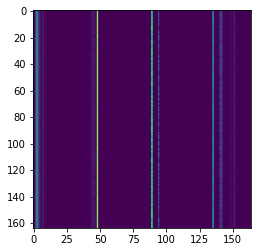

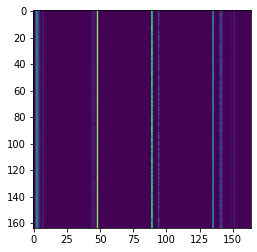

In [15]:
plt.imshow(c620_wt.head(41*4).values)
plt.show()
plt.imshow(c620_wt_gt.head(41*4).values)

In [16]:
predict.model_c620_sf.show_metrics(c620_wt,c620_wt_gt,e=2e-2)

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.941926,0.000716018,1.21829
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.87835,0.347175,1.17904
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0,0.194611,1.04313
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.990472,0.0100336,0.840692
...,...,...,...
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,0.999994,1.63866e-08,0.0273581
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,0.999994,3.01907e-09,0.0273585
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


# check mass blance c620_wt

In [17]:
for i in range(4):
  assert np.allclose(c620_wt.iloc[:,41*i:41*(i+1)].sum(axis=1),100)
print('pass')

pass


In [18]:
input_mfr = predict.c620_mb.iloc[:,0].values.reshape(-1,1)
w1_mfr = predict.c620_mb.iloc[:,1].values.reshape(-1,1)
w2_mfr = predict.c620_mb.iloc[:,2].values.reshape(-1,1)
w3_mfr = predict.c620_mb.iloc[:,3].values.reshape(-1,1)
w4_mfr = predict.c620_mb.iloc[:,4].values.reshape(-1,1)
入料量 = (c620_x.iloc[:,-41:]*input_mfr).sum(axis=1).values
出料_w1 = (c620_wt.iloc[:,0:41]*w1_mfr).sum(axis=1).values
出料_w2 = (c620_wt.iloc[:,41:41*2]*w2_mfr).sum(axis=1).values
出料_w3 = (c620_wt.iloc[:,41*2:41*3]*w3_mfr).sum(axis=1).values
出料_w4 = (c620_wt.iloc[:,41*3:41*4]*w4_mfr).sum(axis=1).values
np.allclose(入料量,出料_w1+出料_w2+出料_w3+出料_w4)

True

#C620 OP

In [19]:
c620_op = predict.c620_op(c620_x)
c620_op.head()

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
028-050,0.862268,0.451691,0.785328,0.878713,0.871925,104.147163,10.529888,12.125898,177.636597,194.008530
086-034,0.864578,0.452374,0.782572,0.881549,0.872118,142.989212,14.283041,16.267033,175.439865,192.186401
034-013,0.862213,0.452630,0.782075,0.879995,0.871897,117.893173,11.789415,13.661718,176.724136,193.770065
024-081,0.862092,0.450218,0.791577,0.878749,0.871936,121.321625,12.376836,14.731828,177.963989,194.682404
051-012,0.862278,0.450879,0.788389,0.880064,0.871885,110.754654,11.222885,12.791360,176.554306,193.544250


In [20]:
c620_op_gt = predict.c620_df.loc[c620_op.index,c620_op.columns]
c620_op_gt.head()

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
028-050,0.862264,0.450406,0.781911,0.878711,0.871920,103.759338,10.453817,12.064047,177.613312,193.994568
086-034,0.864577,0.451177,0.780074,0.881550,0.872119,143.279633,14.340804,16.338560,175.404388,192.173889
034-013,0.862201,0.451472,0.778783,0.880004,0.871894,117.941292,11.775888,13.660801,176.697784,193.788055
024-081,0.862092,0.448472,0.788004,0.878749,0.871939,121.064819,12.355269,14.704895,177.941650,194.671356
051-012,0.862264,0.449451,0.784881,0.880035,0.871885,110.433433,11.197950,12.777924,176.578674,193.559296


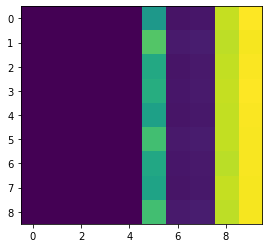

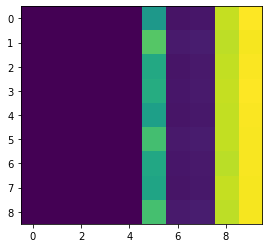

In [21]:
plt.imshow(c620_op.head(9).values)
plt.show()
plt.imshow(c620_op_gt.head(9).values)

In [22]:
predict.model_c620_op.show_metrics(c620_op,c620_op_gt,e=2e-2)

,R2,MSE,MAPE
Density_Feed Properties,0.999953,6.89559e-11,0.000681112
Density_Vent Gas Production Rate and Composition,0.395911,8.41191e-06,0.528015
Density_Distillate Production Rate and Composition,0.388255,4.17207e-05,0.672636
Density_Sidedraw Production Rate and Composition,0.999675,3.6135e-10,0.00165167
Density_Bottoms Production Rate and Composition,0.999683,5.18821e-12,0.000205789
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.998741,0.160327,0.245805
Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.997974,0.00233542,0.289762
Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.998922,0.00172189,0.226086
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.99898,0.00129441,0.016693
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0.99855,0.00114792,0.0136233


#C660 WT

In [23]:
#C660 Input
c660_x = predict.load_c660(c620_wt[predict.c620_col_names['sidedraw_x']])
c660_x.head()

,Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,Combined Feed to Benzene Column C660_Detailed Composition_Hydrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Propane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Butane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Pentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Benzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Cyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Heptane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Water_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Toluene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Octane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_p-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_m-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_o-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Nonane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_Indane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Benzene Column C660_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Nitrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Oxygen_wt%
028-050,950.004612,10.000000,0.0,0.000140,0.009116,0.016954,0.011504,0.014529,0.018943,47.501876,0.011982,0.019993,0.0,0.011168,48.055281,0.018014,0.014750,0.012042,2.067529,0.713900,1.171351,0.205771,0.026324,1.737405e-07,0.058357,3.270775e-08,0.002288,0.002283,4.562177e-03,1.108692e-03,1.109154e-03,0.004624,4.571529e-08,1.863975e-09,0.019604,0.004885,6.836265e-09,0.0,8.687997e-11,4.025838e-12,4.390856e-15,0.0,0.0
086-034,920.000036,10.000006,0.0,0.000129,0.008341,0.015953,0.011160,0.016803,0.027739,65.117344,0.017752,0.029310,0.0,0.012996,28.792527,0.029730,0.025977,0.021246,3.281647,0.662018,1.380040,0.382948,0.046608,3.325320e-08,0.103481,6.136432e-09,0.001196,0.001195,2.336061e-03,5.9

In [24]:
c660_wt = predict.c660_wt(c660_x)
c660_wt.head()

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

In [25]:
c660_wt_gt = predict.c660_df.loc[c660_wt.index,c660_wt.columns]
c660_wt_gt.head()

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

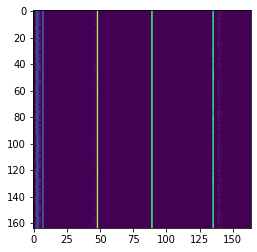

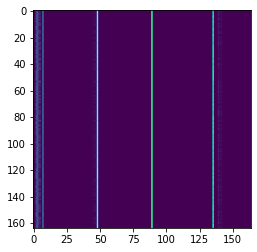

In [26]:
plt.imshow(c660_wt.head(41*4).values)
plt.show()
plt.imshow(c660_wt_gt.head(41*4).values)

In [27]:
predict.model_c660_sf.show_metrics(c660_wt,c660_wt_gt,e=2e-2)

,R2,MSE,MAPE
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.961962,0.00463561,4.41916
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.99148,0.31447,1.99596
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.953988,0.200672,1.39118
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.990427,0.11917,3.63725
...,...,...,...
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,0.999845,2.23996e-27,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,0.999862,2.42684e-33,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


# check mass blance c660_wt

In [28]:
for i in range(4):
  assert np.allclose(c660_wt.iloc[:,41*i:41*(i+1)].sum(axis=1),100)
print('pass')

pass


In [29]:
input_mfr = predict.c660_mb.iloc[:,0].values.reshape(-1,1)
w1_mfr = predict.c660_mb.iloc[:,1].values.reshape(-1,1)
w2_mfr = predict.c660_mb.iloc[:,2].values.reshape(-1,1)
w3_mfr = predict.c660_mb.iloc[:,3].values.reshape(-1,1)
w4_mfr = predict.c660_mb.iloc[:,4].values.reshape(-1,1)
入料量 = (c660_x.iloc[:,-41:]*input_mfr).sum(axis=1).values
出料_w1 = (c660_wt.iloc[:,0:41]*w1_mfr).sum(axis=1).values
出料_w2 = (c660_wt.iloc[:,41:41*2]*w2_mfr).sum(axis=1).values
出料_w3 = (c660_wt.iloc[:,41*2:41*3]*w3_mfr).sum(axis=1).values
出料_w4 = (c660_wt.iloc[:,41*3:41*4]*w4_mfr).sum(axis=1).values
np.allclose(入料量,出料_w1+出料_w2+出料_w3+出料_w4)

True

#C660 OP

In [30]:
c660_op = predict.c660_op(c660_x)
c660_op.head()

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate (Benzene Drag) Production Rate and Composition,Density_Sidedraw (Benzene )Production Rate and Composition,Density_Bottoms Production Rate and Composition,Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC
028-050,0.876419,0.569257,0.855028,0.883697,0.870569,147.620987,13.995810,13.524827,86.713654,90.291519
086-034,0.878541,0.541142,0.866813,0.883710,0.870034,114.764229,11.184323,10.549421,86.500420,89.100441
034-013,0.876752,0.566395,0.856214,0.883697,0.870530,141.719696,13.464311,13.018089,86.670288,90.334259
024-081,0.876962,0.571153,0.854301,0.883735,0.870096,207.277664,19.581383,19.078136,87.290558,92.029320
051-012,0.875791,0.534169,0.869724,0.883698,0.870751,118.507416,11.687229,11.364209,86.534943,89.526451


In [31]:
c660_op_gt = predict.c660_df.loc[c660_op.index,c660_op.columns]
c660_op_gt.head()

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate (Benzene Drag) Production Rate and Composition,Density_Sidedraw (Benzene )Production Rate and Composition,Density_Bottoms Production Rate and Composition,Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC
028-050,0.876404,0.568683,0.855218,0.883697,0.870545,147.730164,14.009640,13.544331,86.715424,90.288269
086-034,0.878549,0.540823,0.866843,0.883710,0.870038,113.617943,11.087483,10.440802,86.494720,89.100037
034-013,0.876760,0.565993,0.856485,0.883698,0.870517,139.476669,13.263507,12.849667,86.654358,90.219421
024-081,0.876908,0.570007,0.855351,0.883737,0.870114,212.536591,20.139593,19.664101,87.347168,92.191864
051-012,0.875875,0.533322,0.869820,0.883697,0.870745,117.552582,11.608797,11.250355,86.528198,89.488342


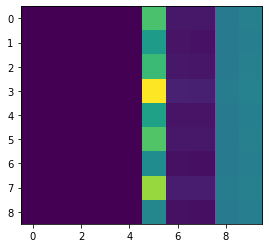

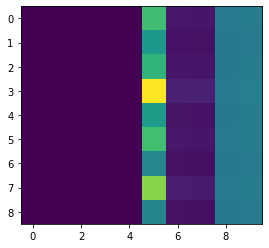

In [32]:
plt.imshow(c660_op.head(9).values)
plt.show()
plt.imshow(c660_op_gt.head(9).values)

In [33]:
predict.model_c660_op.show_metrics(c660_op,c660_op_gt,e=2e-2)

,R2,MSE,MAPE
Density_Feed Properties,0.998186,1.44315e-09,0.00334209
Density_Vent Gas Production Rate and Composition,0.993895,1.88757e-06,0.198228
Density_Distillate (Benzene Drag) Production Rate and Composition,0.993904,4.63255e-07,0.0570653
Density_Sidedraw (Benzene )Production Rate and Composition,0.988336,1.18292e-12,9.48788e-05
Density_Bottoms Production Rate and Composition,0.99892,8.70433e-11,0.000814078
Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,0.998123,1.57961,0.721619
Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.997829,0.0141455,0.714921
Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.99789,0.0147808,0.768653
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0.997736,0.000100838,0.0088302
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC,0.996938,0.00250483,0.0413679


# C670 WT

In [34]:
#C670 Input
c620_w4,c660_w4 = c620_wt[predict.c620_col_names['bottoms_x']],c660_wt[predict.c660_col_names['bottoms_x']]
c670_x = predict.load_c670(c620_w4,c660_w4)
c670_x.head()

,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Hydrogen_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Methane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Propane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Butane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Pentane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Hexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Benzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Heptane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Water_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Toluene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Octane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_p-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_m-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_o-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Nonane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Indane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2-Diethylbenzene_wt%",Tol

In [35]:
c670_wt = predict.c670_wt(c670_x)
c670_wt = c670_wt.dropna(axis=0)
c670_wt.head()

,Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Benzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Heptane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Water_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Toluene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Octane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_p-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_m-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_o-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Nonane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_Indane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2-Diethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,4-Diethylbenzene_wt%","Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Nitrogen_wt%,...,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition

In [36]:
c670_wt_gt = predict.c670_df.loc[c670_wt.index,c670_wt.columns]
c670_wt_gt.head()

,Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Benzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Heptane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Water_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Toluene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Octane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_p-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_m-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_o-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Nonane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_Indane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2-Diethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,4-Diethylbenzene_wt%","Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Nitrogen_wt%,...,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition

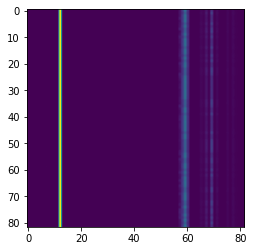

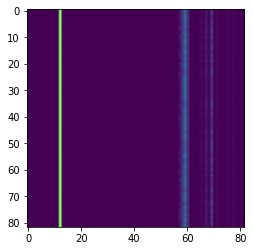

In [37]:
plt.imshow(c670_wt.head(41*2).values)
plt.show()
plt.imshow(c670_wt_gt.head(41*2).values)

In [38]:
predict.model_c670_sf.show_metrics(c670_wt,c670_wt_gt,e=2e-2)

,R2,MSE,MAPE
Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,0,3.8766e-11,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,0,2.26721e-08,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,0,1.81827e-08,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,0,6.15474e-47,NaN
...,...,...,...
Toluene Column C670 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,1,5.7066e-09,0.00687334
Toluene Column C670 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,1,1.0484e-09,0.00682083
Toluene Column C670 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Toluene Column C670 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


# check massblance c670_wt

In [39]:
for i in range(2):
  assert np.allclose(c670_wt.iloc[:,41*i:41*(i+1)].sum(axis=1),100)
print('pass')

pass


In [40]:
input_mfr = predict.c670_mb.iloc[:,[0,1]].sum(axis=1).values.reshape(-1,1)
w1_mfr = predict.c670_mb.iloc[:,2].values.reshape(-1,1)
w2_mfr = predict.c670_mb.iloc[:,3].values.reshape(-1,1)
入料量 = (c670_x.iloc[:,:41]*input_mfr).sum(axis=1).values
出料_w1 = (c670_wt.iloc[:,0:41]*w1_mfr).sum(axis=1).values
出料_w2 = (c670_wt.iloc[:,41:41*2]*w2_mfr).sum(axis=1).values
np.allclose(入料量,出料_w1+出料_w2)

True

#C670 OP

In [41]:
c670_op = predict.c670_op(c670_x)
c670_op.head()

,Density_Distillate Production Rate and Composition,Density_Bottoms Production Rate and Composition,Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC
028-050,0.870914,0.872300,234.796143,27.216513,27.382729,181.183594,224.808075
086-034,0.870910,0.873133,257.836121,29.020658,29.598352,181.391037,228.172592
034-013,0.870920,0.872332,254.015762,29.169312,29.435747,181.362976,225.178604
024-081,0.870873,0.872075,307.353210,34.388542,34.923573,181.856049,225.612564
051-012,0.870942,0.872438,229.750900,26.805010,26.904140,181.185745,224.966522


In [42]:
c670_op_gt = predict.c670_df.loc[c670_op.index,c670_op.columns]
c670_op_gt.head()

,Density_Distillate Production Rate and Composition,Density_Bottoms Production Rate and Composition,Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC
028-050,0.870915,0.872302,233.535889,27.027304,27.215515,181.183899,224.725647
086-034,0.870912,0.873155,254.673035,28.809785,29.365066,181.374206,228.245392
034-013,0.870921,0.872334,254.696258,29.071254,29.410797,181.367950,225.175354
024-081,0.870869,0.872094,305.947266,33.850076,34.513856,181.806213,225.763824
051-012,0.870941,0.872463,229.107376,26.739351,26.873517,181.160156,224.920929


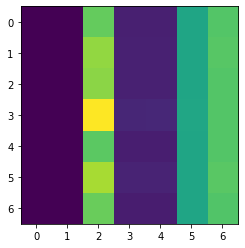

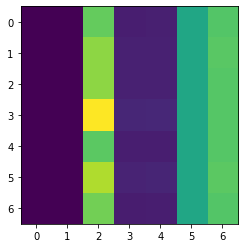

In [43]:
plt.imshow(c670_op.head(7).values)
plt.show()
plt.imshow(c670_op_gt.head(7).values)

In [44]:
predict.model_c670_op.show_metrics(c670_op,c670_op_gt,e=2e-2)

,R2,MSE,MAPE
Density_Distillate Production Rate and Composition,0.996851,2.66179e-12,0.000139197
Density_Bottoms Production Rate and Composition,0.998685,2.36943e-10,0.0013708
Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,0.987298,8.22315,0.855478
Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.988365,0.100524,0.790359
Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.98747,0.104896,0.807939
Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,0.989718,0.000650742,0.010904
Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC,0.995508,0.0113015,0.0326916
AVG,0.991985,1.20579,0.356983
